In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import launch_sim
%load_ext autoreload
%autoreload 2
import time
from random import shuffle

In [26]:
import inspect
import math

In [27]:
class saddle_space:
    def __init__(self):
        self.dim = 2
    
    def fitness(self,psi):
        res = launch_sim(psi)
        return res
    
    def get_bounds(self):
        return ([0,0],[99,99])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
        x,y = zip(*w)
        plt.scatter(x,y,4,'k',edgecolors='face')
        plt.scatter(w[idx][0],w[idx][1],15,'y',edgecolors='k')

In [28]:
class salimans_nes:
    def __init__(self,iter=12):
        super(salimans_nes,self).__init__()
        self.prevx,self.prevy = [],[]
        
        self.iter=iter # number of steps towards estimated gradient
    
    def evolve(self,pop):
        if len(pop) == 0:
            return pop
        sigma = 3
        alpha = 0.03 # learningrate
        
        # plotting
        plotting = False
        if plotting:
            plt.figure(figsize=(self.iter,self.iter))
            no_rows = int(self.iter/4+1)
            gs = gridspec.GridSpec(no_rows,4)
            plot_index = 0
        
        #for each iteration, jitter around starting points, and move in the
        #best direction (weighted average jitter coordinates according to 
        #fitness score)
        for i in range(self.iter):
            
            if plotting:
                ax1=plt.subplot(gs[int(i/4),plot_index])
                plot_index += 1
                if plot_index == 4:
                    plot_index = 0
                plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
            
            #get the population    
            wl = pop.get_x()
            
            #do the jittering and selection
            j=0
            for w in wl:
                noise = np.random.randn(200,2)
                wp = [[min(99,max(0,x)),min(99,max(0,y))] for [x,y] in np.expand_dims(w, 0) + sigma*noise]
                
                
                
                if plotting:
                    x,y = zip(*wp)
                    plt.scatter(x,y,4,'k',edgecolors='face')
                R = np.array([prob.fitness(wi)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
                u = alpha * g
                w += u # mutate the population
                w = [min(99,max(0,w[0])),min(99,max(0,w[1]))] # bounds
                pop.set_x(j,w)# make the move previously selected
                j+=1
        return pop

    def get_name(self):
        return f"Oisin's big-dick omegafantastic algorithm"

In [29]:
def pygmo_es():
    uda = salimans_nes(iter=25)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow

    archi = pg.archipelago(algo=uda, prob=udp, n=50, pop_size=30)
    archi.evolve()
    sols = archi.get_champions_f()
    idx = sols.index(min(sols))
    #print("Done!! Solutions found are: ")
    #print(archi.get_champions_f())
    udp.plot(archi.get_champions_x(),idx)

    #pop = pg.population(prob,10,3)
    #algo.evolve(pop)

In [30]:
from orbsim.constants import *
from orbsim.analyticals import *
from orbsim.simulators import *
derp = launch_sim([-2.09, -0.0001, 3.01])

deny step 0.012179530089969815,0.00020700896068361456
deny step 0.008422064443540723,0.00011975085561621603


In [32]:
if __name__ == '__main__':
    pass
    #pygmo_es()

In [11]:
from mpl_toolkits.mplot3d import Axes3D


In [35]:
xa=[d[0] for d in derp[1]]
ya=[d[1] for d in derp[1]]
ha = [d[4] for d in derp[1]]


ValueError: too many values to unpack (expected 3)

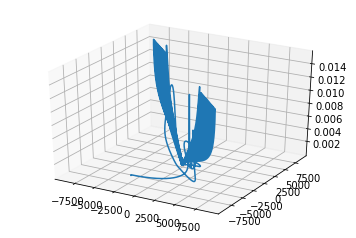

In [24]:
fig = plt.figure()
ax = fig.gca(projection="3d")

ax.plot(xa, ya, ha)

In [34]:
x,y,h

[[-3238.8578420433873, -5667.222681174772, 1e-06],
 [-3238.8533838643807, -5667.222682352816, 9.685751550210831e-06],
 [-3238.8102029041347, -5667.222693887533, 3.0143848398977057e-05],
 [-3238.6758144839487, -5667.222730429864, 5.3177583931389064e-05],
 [-3238.4387326089723, -5667.222794932303, 7.063030774962095e-05],
 [-3238.123835382847, -5667.222878039376, 8.139946537775949e-05],
 [-3237.7609178628004, -5667.222968255128, 8.738514647422495e-05],
 [-3237.3713053040183, -5667.223057312064, 9.054148216143147e-05],
 [-3236.967611565143, -5667.223140436957, 9.216269824255465e-05],
 [-3236.5566807174914, -5667.223215153625, 9.298478876441862e-05],
 [-3236.142075608863, -5667.223280246671, 9.339925014339645e-05],
 [-3235.725613668129, -5667.223335137182, 9.360786472285554e-05],
 [-3235.308212692299, -5667.223379554035, 9.371304922067317e-05],
 [-3234.8903338509303, -5667.223413371354, 9.376639391909484e-05],
 [-3234.472208292082, -5667.223436530725, 9.379378870962557e-05],
 [-3234.0539517

In [11]:
from math import cos, sin

c=[[cos(x/100.0*2*pi),sin(x/100.0*2*pi)] for x in range(100)]
c

[[1.0, 0.0],
 [0.9980267284282716, 0.06279051952931337],
 [0.9921147013144779, 0.12533323356430426],
 [0.9822872507286887, 0.1873813145857246],
 [0.9685831611286311, 0.2486898871648548],
 [0.9510565162951535, 0.3090169943749474],
 [0.9297764858882515, 0.3681245526846779],
 [0.9048270524660195, 0.4257792915650727],
 [0.8763066800438636, 0.4817536741017153],
 [0.8443279255020151, 0.5358267949789967],
 [0.8090169943749475, 0.5877852522924731],
 [0.7705132427757893, 0.6374239897486896],
 [0.7289686274214116, 0.6845471059286886],
 [0.6845471059286886, 0.7289686274214116],
 [0.6374239897486896, 0.7705132427757893],
 [0.5877852522924731, 0.8090169943749475],
 [0.5358267949789965, 0.8443279255020151],
 [0.48175367410171516, 0.8763066800438637],
 [0.42577929156507266, 0.9048270524660196],
 [0.3681245526846781, 0.9297764858882513],
 [0.30901699437494745, 0.9510565162951535],
 [0.24868988716485496, 0.9685831611286311],
 [0.18738131458572474, 0.9822872507286886],
 [0.12533323356430426, 0.992114701

In [12]:
range(0.0,1.0,0.01)

TypeError: 'float' object cannot be interpreted as an integer